In [59]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

import pymc3 as pm
import GPy
import sys

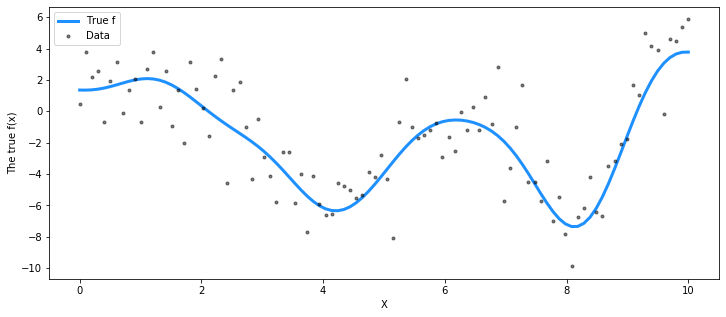

In [32]:
np.random.seed(1)
n = 100

X = np.linspace(0,10,n).reshape(100,1)
lam = 1.0
eta = 3.0

mean_func = pm.gp.mean.Zero()
cov_func = eta**2 * pm.gp.cov.ExpQuad(1, lam)

std_noise = 2.0

f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                        cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()


y = f_true + (std_noise * np.random.randn(n))                 

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

In [33]:
%%time
with pm.Model() as model:
    
    lam_ = pm.Gamma('lam', alpha=2, beta=1)
    eta_ = pm.HalfCauchy('eta', beta=5)
    
    cov = eta_**2 * pm.gp.cov.Matern52(1, lam_)
    
    gp = pm.gp.Marginal(cov_func=cov)
    
    sig_noise_ = pm.HalfCauchy('sigma_noise', beta=5)
    
    y_ = gp.marginal_likelihood('y', X=X, y=y, noise=sig_noise_)
    
    mp = pm.find_MAP()

C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

Wall time: 3min 9s


In [37]:
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp['lam']), float(mp["eta"]), float(mp["sigma_noise"])],
              "True value": [lam, eta, std_noise]})

,Parameter,Value at MAP,True value
0,ℓ,1.229382,1.0
1,η,3.585355,3.0
2,σ,1.901040,2.0


In [41]:
%%time

X_new = np.linspace(0,20,300).reshape(300,1)
with model:
    f_pred = gp.conditional('f_pred', X_new)
    
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=1000)

C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimension

Wall time: 3min 23s


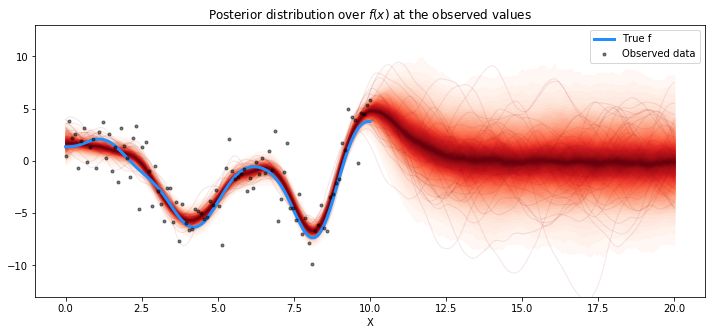

In [43]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [47]:
with model:
    y_pred = gp.conditional('y_pred', X_new, pred_noise=True)
    y_sample = pm.sample_posterior_predictive([mp],vars=[y_pred],samples=1000)

C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Georgy\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimension

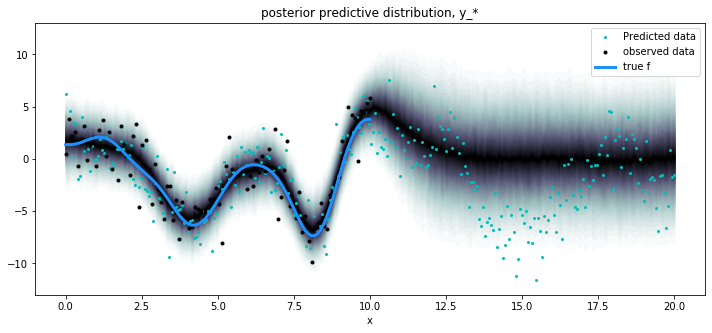

In [49]:

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_sample["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_sample["y_pred"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

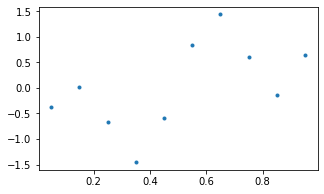

In [60]:
N = 10
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.1, size=(N, 1))
plt.figure(figsize=(5, 3))
plt.plot(X, Y, '.')


Name : GP regression
Objective : 9.718298953659438
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.6645553662361132  |      +ve      |        
  rbf.lengthscale          |  0.11723435026130688  |      +ve      |        
  Gaussian_noise.variance  |                  0.1  |   +ve fixed   |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x27ef5f53cc0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x27ef5f53c50>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x27ef5f602b0>]}

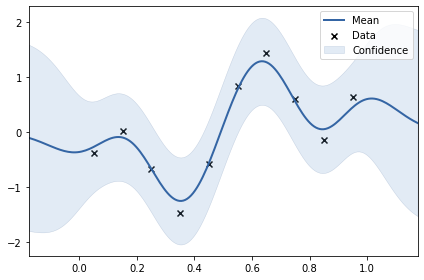

In [79]:
lam = 0.1
eta = 1.0

kernel = GPy.kern.RBF(input_dim = 1, lengthscale=lam, variance=eta)
model = GPy.models.GPRegression(X, Y, kernel, noise_var=0.1)
model.Gaussian_noise.variance.fix(0.1)
model.optimize()
print(model)
model.plot()

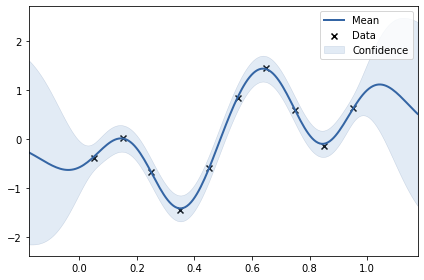

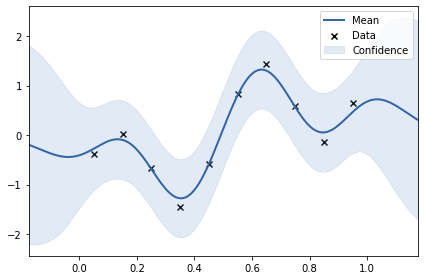

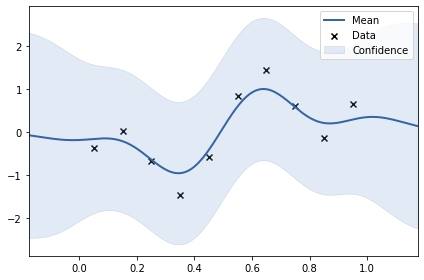

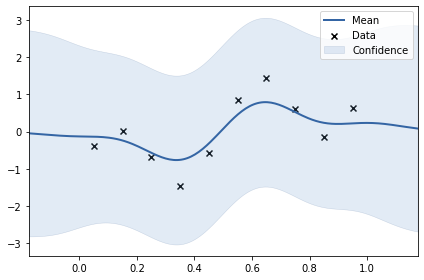

In [78]:
for i in [0.01,0.1,0.5,1]:
    model.Gaussian_noise.variance = i
    model.plot()

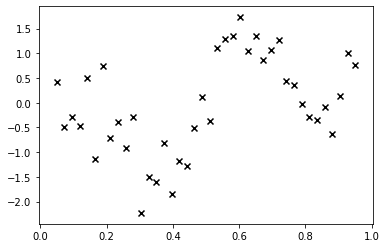

In [83]:
np.random.seed(1)
N = 40
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.5, size=(N, 1))
plt.scatter(X,Y, marker='x', c='black')


Name : GP regression
Objective : 38.487684127401366
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.8711076865548639  |      +ve      |        
  rbf.lengthscale          |  0.11653816022533622  |      +ve      |        
  Gaussian_noise.variance  |                 0.23  |   +ve fixed   |        


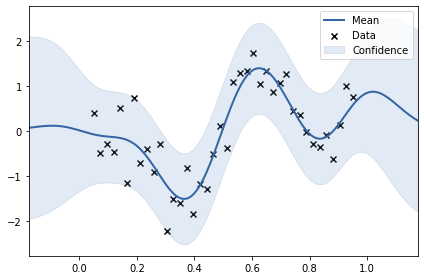

In [91]:
kernel = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X,Y,kernel)
model.Gaussian_noise.variance.fix(0.23)
model.optimize()
print(model)
model.plot()
plt.show()

array([[1949.04166667],
       [1949.125     ],
       [1949.20833333],
       [1949.29166667],
       [1949.375     ],
       [1949.45833333],
       [1949.54166667],
       [1949.625     ],
       [1949.70833333],
       [1949.79166667],
       [1949.875     ],
       [1949.95833333],
       [1950.04166667],
       [1950.125     ],
       [1950.20833333],
       [1950.29166667],
       [1950.375     ],
       [1950.45833333],
       [1950.54166667],
       [1950.625     ],
       [1950.70833333],
       [1950.79166667],
       [1950.875     ],
       [1950.95833333],
       [1951.04166667],
       [1951.125     ],
       [1951.20833333],
       [1951.29166667],
       [1951.375     ],
       [1951.45833333],
       [1951.54166667],
       [1951.625     ],
       [1951.70833333],
       [1951.79166667],
       [1951.875     ],
       [1951.95833333],
       [1952.04166667],
       [1952.125     ],
       [1952.20833333],
       [1952.29166667],
       [1952.375     ],
       [1952.458

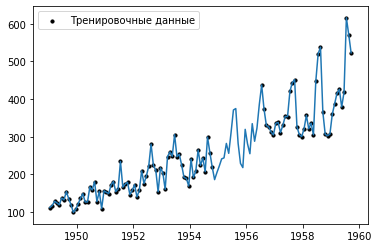

In [407]:
data = np.load('airline.npz')
X = data['X']
y = data['y']

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

plt.plot(X,y)
plt.scatter(X_train, y_train, marker='o', c='black', s=10, label='Тренировочные данные')
plt.legend()

X


Name : GP regression
Objective : 589.505188723038
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  115463.46429523733  |      +ve      |        
  rbf.lengthscale          |  14.498940193262111  |      +ve      |        
  Gaussian_noise.variance  |  2462.0823356240985  |      +ve      |        


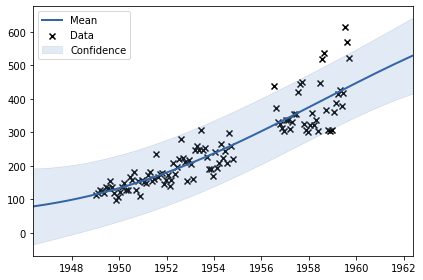

In [110]:
rbf_k = GPy.kern.RBF(1)
model = GPy.models.GPRegression(X_train, y_train, rbf_k)
model.optimize()
print(model)
model.plot()
plt.show()


Name : GP regression
Objective : 589.2011773391707
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  sum.poly.variance        |  0.18932294543759878  |      +ve      |        
  sum.poly.scale           |  0.11635900348193076  |      +ve      |        
  sum.poly.bias            |   3.3926306246972757  |      +ve      |        
  sum.rbf.variance         |   217199.97210041402  |      +ve      |        
  sum.rbf.lengthscale      |    16.71632843755221  |      +ve      |        
  Gaussian_noise.variance  |    2479.759713478674  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x27ef4a5e048>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x27ef4a5e978>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x27ef49eceb8>]}

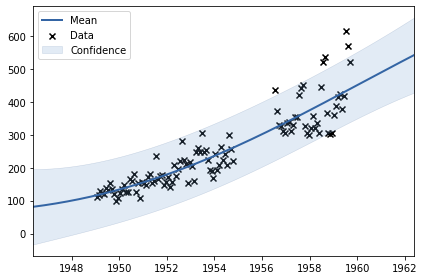

In [114]:
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
model = GPy.models.GPRegression(X_train, y_train, k_trend)
model.optimize()
print(model)
model.plot()


Name : GP regression
Objective : 684.1017571327088
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  GP_regression.                    |                value  |  constraints  |  priors
  sum.poly.variance                 |   0.1309938179336794  |      +ve      |        
  sum.poly.scale                    |  0.13234026505857213  |      +ve      |        
  sum.poly.bias                     |   0.9955446117960638  |      +ve      |        
  sum.rbf.variance                  |   206.06463283123458  |      +ve      |        
  sum.rbf.lengthscale               |   185.28285974524277  |      +ve      |        
  sum.mul.std_periodic.variance     |  0.14372624506327716  |      +ve      |        
  sum.mul.std_periodic.period       |   0.4644300473491638  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |    2.186254336705497  |      +ve      |        
  sum.mul.rbf.variance              |  0.14372624483366372  |      +ve      |     

{'dataplot': [<matplotlib.collections.PathCollection at 0x27ef7935e10>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x27ef7935e48>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x27ef63ae438>]}

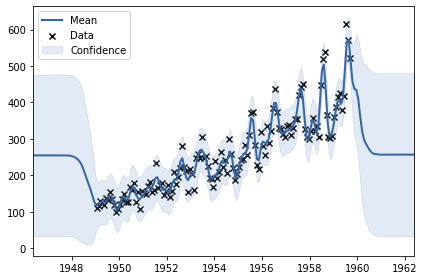

In [116]:
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
k_season = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1) * GPy.kern.Linear(1)
k = k_trend + k_season
model = GPy.models.GPRegression(X, y, k)
model.optimize()
print(model)
model.plot()


Name : GP regression
Objective : 647.8976771436593
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                    |                 value  |  constraints  |  priors
  sum.poly.variance                 |   0.15122447902650576  |      +ve      |        
  sum.poly.scale                    |   0.15124032996754028  |      +ve      |        
  sum.poly.bias                     |    0.9999489208377472  |      +ve      |        
  sum.rbf.variance                  |    197.10159998525515  |      +ve      |        
  sum.rbf.lengthscale               |    0.7616729742050083  |      +ve      |        
  sum.mul.std_periodic.variance     |    0.2133216013991698  |      +ve      |        
  sum.mul.std_periodic.period       |    1.0037596488518228  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |    0.8096775298861728  |      +ve      |        
  sum.mul.rbf.variance              |   0.21332160129052039  |      +ve  

{'dataplot': [<matplotlib.collections.PathCollection at 0x27e9ef66ba8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x27e9ef66b00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x27e9ef40198>]}

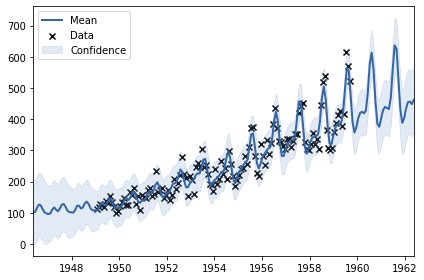

In [379]:
%%time
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
k_season = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1) * GPy.kern.Linear(1)
k_noise = GPy.kern.White(1) * GPy.kern.Linear(1)
k = k_trend + k_season + k_noise

model = GPy.models.GPRegression(X, y, k)
model.optimize()
print(model)
model.plot()